# Fast Marching Method
### Set values for whether you would like to generate new results or just use the JSON that has previously been generated

In [1]:
# Set to true if you want to run the tests again. Otherwise just loads results from JSON
GENERATE_NEW_RESULTS = False

# Set to true if you want to save figures to disk. Change path as needed
SAVE_FIGURES_TO_DISK = False
FIG_SAVE_PATH = "../../thesis/figures"

Load in packages and set options for prettier plots

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from skimage import io
import numpy as np

import concurrent.futures
import json

from helper_funcs import save_fig, make_cache, get_val_arr, MORTON, ROW_ARR, BLOCK_ARR

from data_structures.morton_order import MortonOrder
from data_structures.block_array import BlockArray
from data_structures.row_major_array import RowMajorArray

from algorithms.fmm import fmm

In [3]:
matplotlib.rcParams['figure.figsize'] = (9.0, 4.8)
font = {'size' : 16}
matplotlib.rc('font', **font)

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

## First test that it looks to be correct on a small 2D array

In [4]:
speed_arr = [
    [20,    20,    20, 0.1],
    [0.001, 0.001, 20, 0.2],
    [0.001, 0.001, 20, 0.001],
    [0.001, 20,    20, 20]
]

morton = MortonOrder(picture=speed_arr)

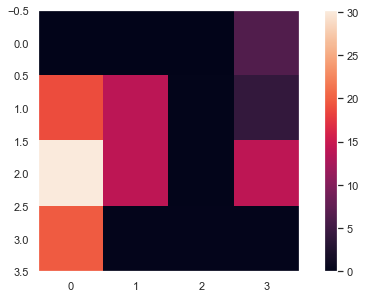

In [5]:
plt.imshow((fmm(morton, (0,0)).to_numpy()))
plt.colorbar()
plt.grid()
plt.show()

## Now test on a blood vessel image

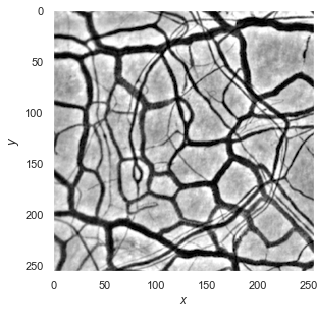

In [6]:
img = io.imread('img/vessels.png', as_gray=True)

plt.imshow(img, cmap='gray')
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.grid()
#plt.title("Original image")
save_fig("vessel-original.pdf", FIG_SAVE_PATH, SAVE_FIGURES_TO_DISK)
plt.show()

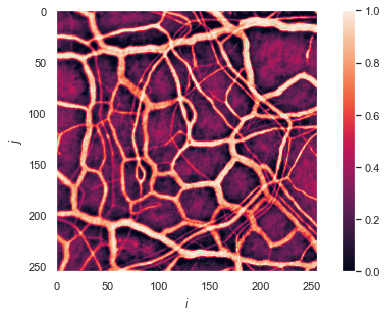

In [7]:
inversed_img = 1.0 - img
plt.imshow(inversed_img)
plt.xlabel("$i$")
plt.ylabel("$j$")
plt.grid()
#plt.title("Speed function $f_{ij}$")
plt.colorbar()
save_fig("speed-func.pdf", FIG_SAVE_PATH, SAVE_FIGURES_TO_DISK)
plt.show()

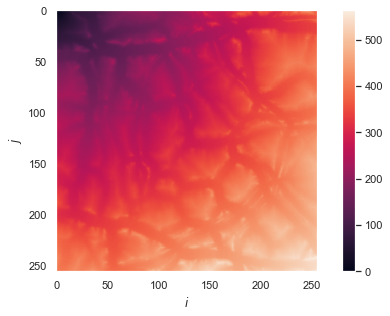

In [8]:
start_point = (0, 0)
morton = BlockArray(inversed_img)
tij = fmm(morton, start_point)


plt.imshow(tij.to_numpy())
plt.xlabel("$i$")
plt.ylabel("$j$")
plt.grid()
plt.colorbar()
save_fig("time-func-00.pdf", FIG_SAVE_PATH, SAVE_FIGURES_TO_DISK)
plt.show()

(128, 128)


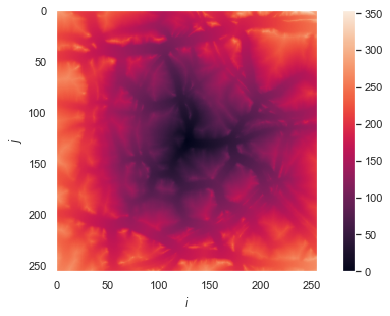

In [9]:
start_point = (256//2, 256//2)
print(start_point)
morton = MortonOrder(inversed_img)
tij = fmm(morton, start_point)


plt.imshow(tij.to_numpy())
plt.xlabel("$i$")
plt.ylabel("$j$")
plt.grid()
#plt.title("Time function $T_{ij}$ originating from " + str(start_point))
plt.colorbar()
save_fig("time-func-mid.pdf", FIG_SAVE_PATH, SAVE_FIGURES_TO_DISK)
plt.show()

## Defining functions/variables to run tests

In [10]:
def results_for_n(n, dim):    
    cs1 = make_cache()
    cs2 = make_cache()
    cs3 = make_cache()
    
    start = (0, 0) if dim == 2 else (0, 0, 0)
    rnd_vals = np.random.rand(n, n) if dim == 2 else np.random.rand(n, n, n)
    
    morton = MortonOrder(rnd_vals, cache=cs1)
    row_arr = RowMajorArray(rnd_vals, cache=cs2)
    block_arr = BlockArray(rnd_vals, cache=cs3)

    # Warm up
    fmm(morton, start)
    fmm(row_arr, start)
    fmm(block_arr, start)

    # Reset caches
    cs1.force_write_back()
    cs1.reset_stats()
    cs2.force_write_back()
    cs2.reset_stats()
    cs3.force_write_back()
    cs3.reset_stats()

    # Do actual test
    fmm(morton, start)
    fmm(row_arr, start)
    fmm(block_arr, start)
    
    cs1.force_write_back()
    cs2.force_write_back()
    cs3.force_write_back()

    obj = {}
    obj[MORTON] = list(cs1.stats())
    obj[ROW_ARR] = list(cs2.stats())
    obj[BLOCK_ARR] = list(cs3.stats())
    print(f"{n} finished")
    return obj

In [11]:
ns_2d = [2**i for i in range(4, 12)]
print(ns_2d)

ns_3d = [2**i for i in range(4, 8)]
print(ns_3d)

[16, 32, 64, 128, 256, 512, 1024, 2048]
[16, 32, 64, 128]


## Generating/loading in test results

### 2D
NB: For some reason `concurrent.futures` kept erroring out, so only done on a single core

In [12]:
if GENERATE_NEW_RESULTS:
    np.random.seed(0)  # Make results reproducable
    dim = 2

    results_2d = {}
    for n in ns_2d:
        print(n)
        results_2d[n] = results_for_n(n, dim)
        
    with open('results/fmm-result-2d.json', 'w') as f:
        json.dump(results_2d, f, indent=4)
else:
    with open('results/fmm-result-2d.json', 'r') as f:
        results_2d = json.load(f)

## 3D

In [13]:
if GENERATE_NEW_RESULTS:
    np.random.seed(0)  # Make results reproducable
    dim = 3

    results_3d = {}
    for n in ns_3d:
        print(n)
        results_3d[n] = results_for_n(n, dim)

    with open('results/fmm-result-3d.json', 'w') as f:
        json.dump(results_3d, f, indent=4)
else:
    with open('results/fmm-result-3d.json', 'r') as f:
        results_3d = json.load(f)

## Plotting

In [14]:
def make_plot(dim, cache_level=0, stat="HIT_count"):
    results = results_2d if dim == 2 else results_3d
    labels = ns_2d if dim == 2 else ns_3d

    row_arr_res = get_val_arr(results, ROW_ARR, stat=stat)
    morton_res = get_val_arr(results, MORTON, stat=stat) / row_arr_res
    block_arr_res = get_val_arr(results, BLOCK_ARR, stat=stat) / row_arr_res
    row_arr_res = row_arr_res / row_arr_res # All 1's

    x = np.arange(len(labels))  # the label locations
    width = 0.20  # the width of the bars
    block_arr_name = "PixelBlockArray" if dim == 2 else "VoxelBlockArray"

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width, morton_res, width, label="MortonOrder")
    rects2 = ax.bar(x, row_arr_res, width, label="RowMajorArray")
    rects3 = ax.bar(x + width, block_arr_res, width, label=block_arr_name)

    ax.set_ylabel(f"Relatve {stat}")
    ax.set_xlabel("$n$")
    ax.set_title(f"Relatve {stat} (scaled by RowMajorArray) during {dim}D FMM")
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend(loc=4)

    fig.tight_layout()
    save_fig(f"fmm-{stat}-{dim}d.pdf", FIG_SAVE_PATH, SAVE_FIGURES_TO_DISK)

    plt.show()

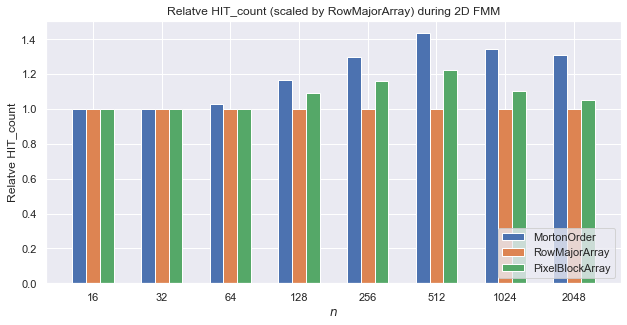

In [15]:
make_plot(2)

Note: Errors out because of zero-division (because of no cache misses), but plot comes out correct

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


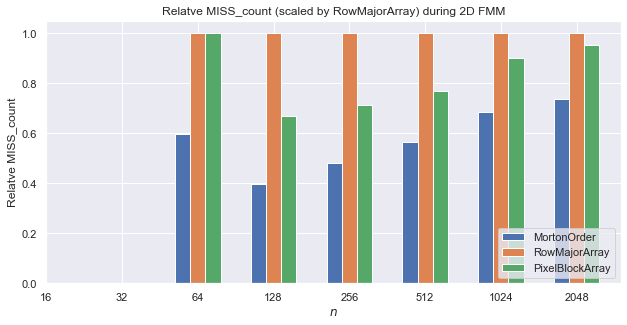

In [16]:
make_plot(2, stat="MISS_count")

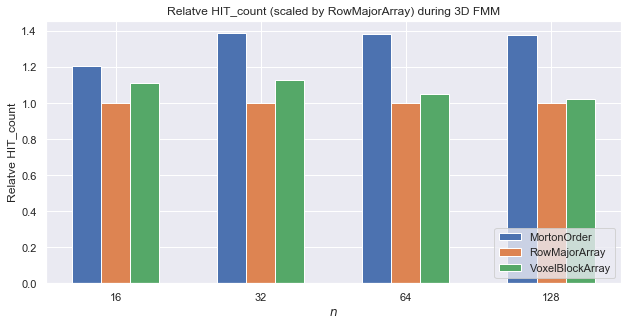

In [17]:
make_plot(3)

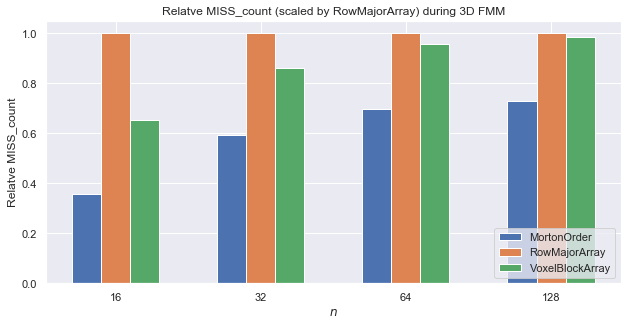

In [18]:
make_plot(3, stat="MISS_count")